In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
9268,other,quizas demasiado caro para lo que es. de momen...
73735,other,De persoon begint een vuurtje te stoken.
56801,other,"Desastroso,No coincidía con el que compré y ad..."
41683,other,包装是坏的，而且第二次发还是坏的，被晒得很烫
51143,other,โอเปร่า จีน
...,...,...
60339,other,Введите Европу
85950,other,Plus epaisse que les autres housses que j’ai p...
21169,other,Tôi sẽ ăn nó miễn là tôi không ở quanh đây tro...
64425,other,周游 品味 人生百态 羡慕女孩可以体会一种不一样的人生


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,Введите Европу
23996,other,Plus epaisse que les autres housses que j’ai p...
23997,other,Tôi sẽ ăn nó miễn là tôi không ở quanh đây tro...
23998,other,周游 品味 人生百态 羡慕女孩可以体会一种不一样的人生


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.30it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.70it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.49it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.26it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.22it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.32it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.78it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.98it/s]


Processing page 8 of 8...


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  5.23it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.85it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [17]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [18]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [19]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [20]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [21]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [22]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [23]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [26]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [27]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), search_url, max_scrolls=10, verbose=True)

Scrolling (0 out of max 10)...
Scrolling (1 out of max 10)...
Scrolling (2 out of max 10)...
Scrolling (3 out of max 10)...
Scrolling (4 out of max 10)...
Scrolling (5 out of max 10)...
Scrolling (6 out of max 10)...
Scrolling (7 out of max 10)...
Scrolling (8 out of max 10)...
Scrolling (9 out of max 10)...
Scrolling (10 out of max 10)...


In [28]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,\n\nΑντώνης Ρέμος - Χίλια Σπίρτα - Official Mu...,/watch?v=sTyGh6edBRQ&pp=ygUjzrXOu867zrfOvc65zr...
1,"\n\nΠουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, ...",/watch?v=cOGip_clrKY&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nΈντεχνα Ελληνικά Live | Γλυκές Περιπλανήσε...,/watch?v=nUCZkuwPwGg&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Που...,/watch?v=C4f3xcZzr3s&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nΌμορφα ελληνικά τραγούδια\n,/watch?v=UIfND1RykJc&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
178,\n\nΑν το Encanto είχε ελληνικά τραγούδια... 🎶\n,/shorts/XgChHFHziKc
179,\n\nΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ\n,/watch?v=OtMFMWuQgCo&pp=ygUjzrXOu867zrfOvc65zr...
180,\n\nΚουκουβάγια- Παιδικό Τραγουδάκι -Greek N...,/watch?v=olq2DyQ_mNU&pp=ygUjzrXOu867zrfOvc65zr...
181,\n\nΕλληνικά pop τραγούδια 80s-90s (mix)\n,/watch?v=Kta2v6W6-vQ&pp=ygUjzrXOu867zrfOvc65zr...


In [29]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
1,"Πουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, Μπέλ...",https://www.youtube.com/watch?v=cOGip_clrKY&pp...
2,Έντεχνα Ελληνικά Live | Γλυκές Περιπλανήσεις |...,https://www.youtube.com/watch?v=nUCZkuwPwGg&pp...
3,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
4,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...
...,...,...
178,Αν το Encanto είχε ελληνικά τραγούδια... 🎶,https://www.youtube.com/shorts/XgChHFHziKc
179,ΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ,https://www.youtube.com/watch?v=OtMFMWuQgCo&pp...
180,Κουκουβάγια- Παιδικό Τραγουδάκι -Greek Nurse...,https://www.youtube.com/watch?v=olq2DyQ_mNU&pp...
181,Ελληνικά pop τραγούδια 80s-90s (mix),https://www.youtube.com/watch?v=Kta2v6W6-vQ&pp...


In [30]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
1,"Πουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, Μπέλ...",https://www.youtube.com/watch?v=cOGip_clrKY&pp...
2,Έντεχνα Ελληνικά Live | Γλυκές Περιπλανήσεις |...,https://www.youtube.com/watch?v=nUCZkuwPwGg&pp...
3,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
4,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...
...,...,...
178,Αν το Encanto είχε ελληνικά τραγούδια... 🎶,https://www.youtube.com/shorts/XgChHFHziKc
179,ΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ,https://www.youtube.com/watch?v=OtMFMWuQgCo&pp...
180,Κουκουβάγια- Παιδικό Τραγουδάκι -Greek Nurse...,https://www.youtube.com/watch?v=olq2DyQ_mNU&pp...
181,Ελληνικά pop τραγούδια 80s-90s (mix),https://www.youtube.com/watch?v=Kta2v6W6-vQ&pp...


In [31]:
import bs4
import threading


def scrape_job(yt_url: str) -> tuple[str, bs4.BeautifulSoup]:
    try:
        result = scrape_youtube(ChromeDriverManager.get(), 
                                yt_url, 
                                scroll_wait_secs=2,
                                max_scrolls=15,
                                verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [32]:
import concurrent.futures


jobs = 15
# get at most max_videos, if more videos were crawled during the search
max_videos = 150
urls = gr_res_df.link[:max_videos] if len(gr_res_df) > max_videos else gr_res_df

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))

ChromeDriverManager.quit()

Scrapping comments...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [04:17<00:00,  1.72s/it]


In [33]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

for url, result in results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

In [34]:
comments_df = pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Super Mix Dankeschön Greetings from Germany,2023-10-25 13:36:45.279617
1,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,"Beautiful music, beautiful language, beautiful...",2022-11-25 13:36:45.284617
2,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Ένα απ' τα καλύτερα μιξ που έχω ακούσει ποτέ!,2021-11-25 13:36:45.287617
3,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Να και ενα ωραιο μιξ!μπραβο παιδια!,2022-11-25 13:36:45.290718
4,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Τα πιο ωραία τραγούδια Μπράβο σας,2022-11-25 13:36:45.293615
...,...,...,...
394,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,!,2023-04-25 13:36:47.126211
395,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,,2023-10-25 13:36:47.130436
396,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Yy5,2022-11-25 13:36:47.133472
397,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,96?,2022-11-25 13:36:47.136469


In [35]:
comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)

preds = greeklish_model.predict(comments_df.text)
mask = ((preds != "el") & (preds != "greeklish"))
comments_df[mask]

,link,text,date
0,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Super Mix Dankeschön Greetings from Germany,2023-10-25
1,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,"Beautiful music, beautiful language, beautiful...",2022-11-25
6,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Felicidades Súper Mix.... Besós desde España,2022-11-25
7,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,BEUTIFUL love it..,2022-11-25
10,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Thanks for putting timed songs. Easy to find m...,2022-11-25
...,...,...,...
394,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,!,2023-04-25
395,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,,2023-10-25
396,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Yy5,2022-11-25
397,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,96?,2022-11-25


In [36]:
crawl_df = pd.merge(gr_res_df, comments_df[~mask], how="inner", on="link")
crawl_df

,title,link,text,date
0,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Ένα απ' τα καλύτερα μιξ που έχω ακούσει ποτέ!,2021-11-25
1,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Να και ενα ωραιο μιξ!μπραβο παιδια!,2022-11-25
2,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Τα πιο ωραία τραγούδια Μπράβο σας,2022-11-25
3,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Χωρίς τη μουσική ο κόσμος θα ήταν γκρι. Η μουσ...,2022-11-25
4,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...,Ένα απ' τα καλύτερα μιξ που έχω ακούσε.ιΩραία ...,2022-11-25
...,...,...,...,...
251,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,το εχετε ξεφτιλισει με τις διαφημιςεις μουσικη...,2022-11-25
252,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ωραία τραγούδια αλλά πολύ διαφήμιση κάθε τόσο ...,2022-11-25
253,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Όχι το δικό μας το χαϊβάνι έκανε παιχνιδάκια μ...,2022-11-25
254,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Καλά ούτε ένα σφακιανάκη ντροπή,2022-11-25


In [37]:
sum(crawl_df.date == None)

0

In [38]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


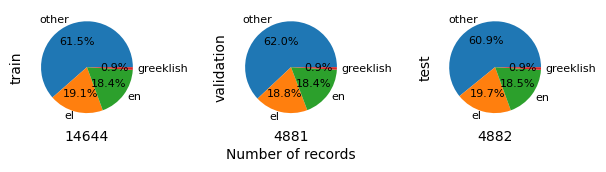

In [41]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [58]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [43]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [44]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.1891633770533554
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       962
          en       0.00      0.00      0.00       903
   greeklish       0.00      0.00      0.00        46
       other       0.61      1.00      0.76      2971

    accuracy                           0.61      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.37      0.61      0.46      4882



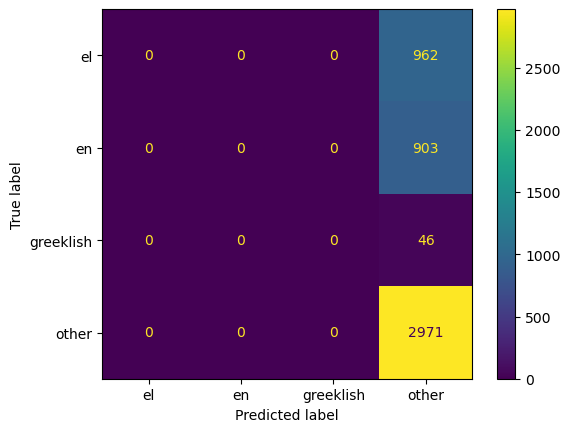

In [45]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5091, std: 0.5024


Macro F1: 0.5086202972420182
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       962
          en       0.32      1.00      0.49       903
   greeklish       0.00      0.00      0.00        46
       other       1.00      0.38      0.55      2971

    accuracy                           0.61      4882
   macro avg       0.58      0.59      0.51      4882
weighted avg       0.86      0.61      0.62      4882



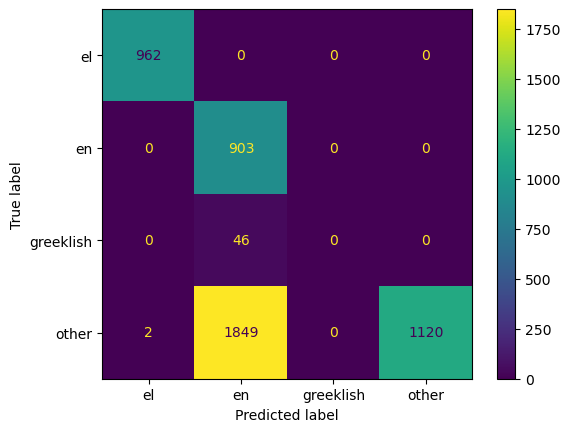

In [47]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8556, std: 0.8442


Macro F1: 0.8897023117025014
              precision    recall  f1-score   support

          el       1.00      0.94      0.97       962
          en       1.00      0.97      0.98       903
   greeklish       1.00      0.46      0.63        46
       other       0.96      1.00      0.98      2971

    accuracy                           0.98      4882
   macro avg       0.99      0.84      0.89      4882
weighted avg       0.98      0.98      0.98      4882



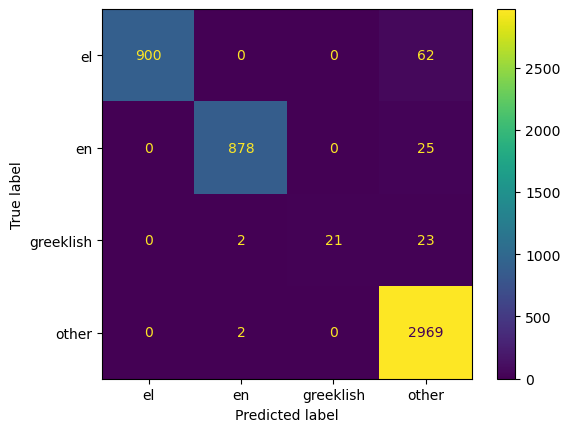

In [49]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [50]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9310, std: 0.9271


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9550203058680564
              precision    recall  f1-score   support

          el       1.00      0.98      0.99       962
          en       0.98      0.99      0.99       903
   greeklish       1.00      0.74      0.85        46
       other       0.99      1.00      0.99      2971

    accuracy                           0.99      4882
   macro avg       0.99      0.93      0.96      4882
weighted avg       0.99      0.99      0.99      4882



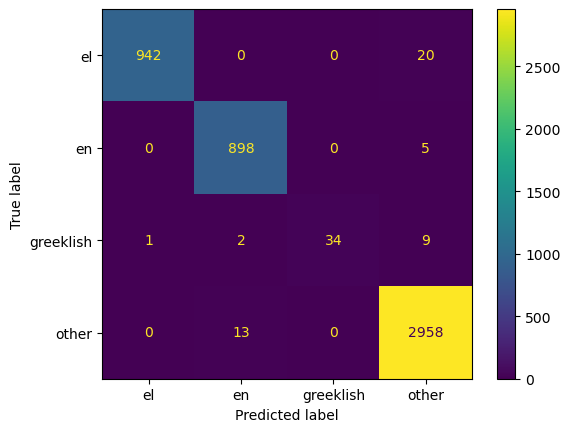

In [51]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [52]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.8740, std: 0.8428


Macro F1: 0.9058508568145229
              precision    recall  f1-score   support

          el       0.99      0.88      0.93       962
          en       0.97      0.94      0.95       903
   greeklish       0.82      0.72      0.77        46
       other       0.95      0.99      0.97      2971

    accuracy                           0.96      4882
   macro avg       0.93      0.88      0.91      4882
weighted avg       0.96      0.96      0.96      4882



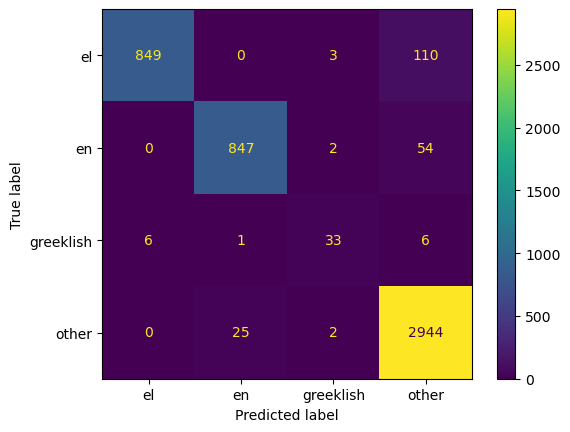

In [53]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [54]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
9932,en,other,"Mặt khác, có những trách nhiệm cần phải giữ lạ..."
8421,other,en,"This thing is EXACTLY what is described, 10/10"
1350,other,el,Η πτολεμαϊκό εποχή έφτασε στο τέλος της με την...
1444,other,el,"Τίποτα , κυρία κάβεντις ;"
3537,other,el,Η Συμμαχία Φράνκο-Πιεμοντέζα παίρνει τη λομβαρ...
...,...,...,...
22819,en,other,Oh yeah it ' s amazing how mboga kilogram will...
2208,other,en,A rubbish I bought this time. Absobuly hate th...
5217,other,el,Λειτουργική διασύνδεση συστημάτων ( osi )
6105,other,el,Σχεδόν ποτέ . ' '


In [55]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
1444,other,el,"Τίποτα , κυρία κάβεντις ;"
2605,other,el,Υπόγειες δεξαμενές αποθήκευσης
15081,en,other,We will meet you back hapa usiku wa leo
23944,en,other,I ' m amazing napenda hizo movie i really do
1865,other,en,WERE IMPROPERLY SEWEN
22549,en,other,"you wanted my uncle , david arnold hanson ."
3100720,other,greeklish,discord? giati in game den vriskw kanenan!
10019,en,other,No she didn ' t even take the gunia huyu ni yu...
3101189,other,greeklish,kane upomoni tha vreis
2995730,other,greeklish,....deleted.


### Hyperparameter tuning

In [66]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 15, stop = 600, num = 10)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:54<00:00, 41.42s/it]


In [67]:
best_model = estimators[np.argmax(scores)]

print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_estimators=600, n_jobs=-1) with macro F1 score of 0.9659623525862466


In [56]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 12 minutes and 15.8 seconds
